# Packages

In [1]:
using Pkg; Pkg.activate("."); 
using CSV
using MUST  # For the models
using TSO   # For the EoS
using PyPlot
using DelimitedFiles
using DataFrames
using Glob;

  Activating environment at `/mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/examples/initial_models/Project.toml`


In [2]:
eos = reload(SqEoS, "/home/eitner/shared/TS_opacity_tables/opacity_tables/DIS_MARCS_v0.5.5.1/eos.hdf5");

# Infrastructure

In [3]:
struct StaggerGrid{DF<:DataFrame}
    name :: String
    info :: DF
end

we first create an info csv file, that will represent the Stagger grid

In [4]:
folder = "/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/"
listOfFolders = [f[1:end-1] for f in glob("*/", folder) if isdir(f)]
listOfFolderNames = [f[first(findlast("/", f))+1:end] for f in listOfFolders]

FolderNamesMask   = [f[1]=='t' for f in listOfFolderNames]
listOfFolders     = listOfFolders[FolderNamesMask]
listOfFolderNames = listOfFolderNames[FolderNamesMask];

In [5]:
## only for Remo sub-folder

#for (i, f) in enumerate(listOfFolders)
#    f_intern = glob("*/", f)
#    f_intern = f_intern[isdir.(f_intern)]
#    if length(f_intern) > 1
#        @warn "there are more than one entried in $(f)"
#    end
#    f_intern = f_intern |> first
#   
#    listOfFolders[i] = f_intern
#end

In [6]:
meshFiles = ["" for _ in listOfFolders]
snapshots = ["" for _ in listOfFolders]
isPresent  = trues(length(meshFiles))

for (i, f) in enumerate(listOfFolders)
    mesh_file = glob("*.msh", f)
    
    mesh_file = if length(mesh_file) == 0
        #@warn "No mesh file in $(f)"
        isPresent[i] = false
        nothing
    elseif length(mesh_file) > 1
        @warn "More than one mesh file present in $(f)"
        fist(mesh_file)
    else
        first(mesh_file)
    end

    meshFiles[i] = isnothing(mesh_file) ?  "" : basename(mesh_file)



    snap_file = glob("*.aux", f)
    
    snap_file = if length(snap_file) == 0
        #@warn "No snap file in $(f)"
        isPresent[i] = false
        nothing
    elseif length(snap_file) > 1
        #@warn "More than one snap file present in $(f)"
        rand(snap_file)
    else
        fist(snap_file)
    end

    snapshots[i] = isnothing(snap_file) ? "" : basename(snap_file)[1:findlast('.', snap_file |> basename)-1]
end


info = DataFrame(Dict("name"=>listOfFolderNames[isPresent], "folder"=>listOfFolders[isPresent], "mesh"=>meshFiles[isPresent], "snapshot"=>snapshots[isPresent]));

In [7]:
info

Row,folder,mesh,name,snapshot
,String,String,String,String
1,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t45g20m00,t45g20m00.msh,t45g20m00,t45g20m00_00168
2,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t45g20m20,t45g20m20.msh,t45g20m20,t45g20m20_00094
3,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t45g20m40,t45g20m40.msh,t45g20m40,t45g20m40_00010
4,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t45g40m00,t45g40m00.msh,t45g40m00,t45g40m00_00031
5,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t5777g44m00,t5777g44m0005.msh,t5777g44m00,t5777g44m0005_00030
6,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t65g40m20,t65g40m20.msh,t65g40m20,t65g40m20_00063
7,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t65g40m40,t65g40m40.msh,t65g40m40,t65g40m40_00048
8,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t70g45m00,t70g45m00.msh,t70g45m00,t70g45m00_00036


Now we add information of the models and the preferred snapshot etc.

In [8]:
function model_properties(name, path, snap_name)
    ## we get the temperature and logg from the name only at this stage
    teff =  parse(Float64, name[2:findfirst('g', name)-1]) .*100
    logg =  parse(Float64, name[findfirst('g', name)+1:findfirst('m', name)-1]) ./10
    feh  = -parse(Float64, name[findfirst('m', name)+1:end]) ./10

    b = MUST.Box(MUST.StaggerSnap(snap_name, path))

    T = MUST.plane_statistic(MUST.mean, b, :T)
    d = MUST.plane_statistic(MUST.mean, b, :d)
    z = MUST.axis(b, :z)

    #initial_model = SimpleInitialModel(teff, logg, z, T, log.(d))
    
    open("$(snap_name)_av.dat", "w") do f
        writedlm(f, [z T log.(d)])
    end

    ## save return the additional column values
    teff, logg, feh, minimum(b[:x]), maximum(b[:x]), minimum(b[:y]), maximum(b[:y]), minimum(b[:z]), maximum(b[:z]), abspath("$(snap_name)_av.dat")
end

model_properties (generic function with 1 method)

In [9]:
teff, logg, feh, mi_x, ma_x, mi_y, ma_y, mi_z, ma_z, av_path = [], [], [], [], [], [], [], [], [], []

for i in 1:nrow(info)
    @info "processing $(info[i, "name"])"
    res = model_properties(info[i, "name"], info[i, "folder"], info[i, "snapshot"])

    append!(teff,    [res[1]])
    append!(logg,    [res[2]])
    append!(feh,     [res[3]])
    append!(mi_x,    [res[4]])
    append!(ma_x,    [res[5]])
    append!(mi_y,    [res[6]])
    append!(ma_y,    [res[7]])
    append!(mi_z,    [res[8]])
    append!(ma_z,    [res[9]])
    append!(av_path, [res[10]])
end

┌ Info: processing t45g20m00
└ @ Main /home/eitner/shared/model_grid/examples/initial_models/from_stagger.ipynb:4
┌ Info: Increase number of points from 238 to 440
└ @ MUST /mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/src/_atmos2legacy.jl:173


┌ Info: processing t45g20m20
└ @ Main /home/eitner/shared/model_grid/examples/initial_models/from_stagger.ipynb:4
┌ Info: Increase number of points from 238 to 351
└ @ MUST /mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/src/_atmos2legacy.jl:173


┌ Info: processing t45g20m40
└ @ Main /home/eitner/shared/model_grid/examples/initial_models/from_stagger.ipynb:4
┌ Info: Increase number of points from 238 to 440
└ @ MUST /mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/src/_atmos2legacy.jl:173


┌ Info: processing t45g40m00
└ @ Main /home/eitner/shared/model_grid/examples/initial_models/from_stagger.ipynb:4
┌ Info: Increase number of points from 238 to 445
└ @ MUST /mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/src/_atmos2legacy.jl:173


┌ Info: processing t5777g44m00
└ @ Main /home/eitner/shared/model_grid/examples/initial_models/from_stagger.ipynb:4
┌ Info: Increase number of points from 238 to 445
└ @ MUST /mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/src/_atmos2legacy.jl:173


┌ Info: processing t65g40m20
└ @ Main /home/eitner/shared/model_grid/examples/initial_models/from_stagger.ipynb:4
┌ Info: Increase number of points from 238 to 636
└ @ MUST /mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/src/_atmos2legacy.jl:173


┌ Info: processing t65g40m40
└ @ Main /home/eitner/shared/model_grid/examples/initial_models/from_stagger.ipynb:4
┌ Info: Increase number of points from 238 to 579
└ @ MUST /mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/src/_atmos2legacy.jl:173


┌ Info: processing t70g45m00
└ @ Main /home/eitner/shared/model_grid/examples/initial_models/from_stagger.ipynb:4
┌ Info: Increase number of points from 238 to 510
└ @ MUST /mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/src/_atmos2legacy.jl:173


In [10]:
info[!, "teff"]    = teff
info[!, "logg"]    = logg
info[!, "feh"]     = feh
info[!, "mi_x"]    = mi_x
info[!, "ma_x"]    = ma_x
info[!, "mi_y"]    = mi_y
info[!, "ma_y"]    = ma_y
info[!, "mi_z"]    = mi_z
info[!, "ma_z"]    = ma_z
info[!, "av_path"] = av_path;

In [11]:
CSV.write("stagger_grid.mgrid", info)

"stagger_grid.mgrid"

In [12]:
# copy the average profiles to the source folders
for i in 1:nrow(info)
    av_name = basename(info[i, "av_path"])
    dest    = joinpath(info[i, "folder"], av_name)

    #cp(info[i, "av_path"], dest)
end

# Load the Grid

In [13]:
StaggerGrid(path) = begin
    info = CSV.read(path, DataFrame)
    name = basename(path)[1:findlast('.', basename(path))-1]

    StaggerGrid(name, info)
end

StaggerGrid

In [14]:
grid = StaggerGrid("stagger_grid.mgrid");

In [15]:
grid.info

Row,folder,mesh,name,snapshot,teff,logg,feh,mi_x,ma_x,mi_y,ma_y,mi_z,ma_z,av_path
,String,String31,String15,String31,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String
1,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t45g20m00,t45g20m00.msh,t45g20m00,t45g20m00_00168,4500.0,2.0,-0.0,0.0,2.39e11,0.0,2.39e11,-8.85898e10,2.62912e10,/mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/examples/initial_models/t45g20m00_00168_av.dat
2,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t45g20m20,t45g20m20.msh,t45g20m20,t45g20m20_00094,4500.0,2.0,-2.0,0.0,1.69292e11,0.0,1.69292e11,-4.62167e10,1.93811e10,/mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/examples/initial_models/t45g20m20_00094_av.dat
3,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t45g20m40,t45g20m40.msh,t45g20m40,t45g20m40_00010,4500.0,2.0,-4.0,0.0,1.49375e11,0.0,1.49375e11,-5.08822e10,2.16435e10,/mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/examples/initial_models/t45g20m40_00010_av.dat
4,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t45g40m00,t45g40m00.msh,t45g40m00,t45g40m00_00031,4500.0,4.0,-0.0,0.0,1.39417e9,0.0,1.39417e9,-5.99664e8,1.69718e8,/mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/examples/initial_models/t45g40m00_00031_av.dat
5,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t5777g44m00,t5777g44m0005.msh,t5777g44m00,t5777g44m0005_00030,577700.0,4.4,-0.0,0.0,7.96667e8,0.0,7.96667e8,-2.93971e8,9.57648e7,/mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/examples/initial_models/t5777g44m0005_00030_av.dat
6,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t65g40m20,t65g40m20.msh,t65g40m20,t65g40m20_00063,6500.0,4.0,-2.0,0.0,1.99167e9,0.0,1.99167e9,-1.0953e9,3.0781e8,/mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/examples/initial_models/t65g40m20_00063_av.dat
7,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t65g40m40,t65g40m40.msh,t65g40m40,t65g40m40_00048,6500.0,4.0,-4.0,0.0,2.19083e9,0.0,2.19083e9,-1.07635e9,3.31133e8,/mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/examples/initial_models/t65g40m40_00048_av.dat
8,/mnt/beegfs/gemini/groups/bergemann/users/shared-storage/bergemann-data/Stagger_zaz/grid/t70g45m00,t70g45m00.msh,t70g45m00,t70g45m00_00036,7000.0,4.5,-0.0,0.0,1.09542e9,0.0,1.09542e9,-4.64059e8,1.2535e8,/mnt/beegfs/gemini/groups/bergemann/users/eitner/model_grid/MUST.jl/examples/initial_models/t70g45m00_00036_av.dat


# Look at the average profiles

In [16]:
Models(grid::StaggerGrid) = begin 
    [Average3D(grid.info[i, "av_path"], logg=grid.info[i, "logg"]) for i in 1:nrow(grid.info)]
end

Models (generic function with 1 method)

In [17]:
models = Models(grid);

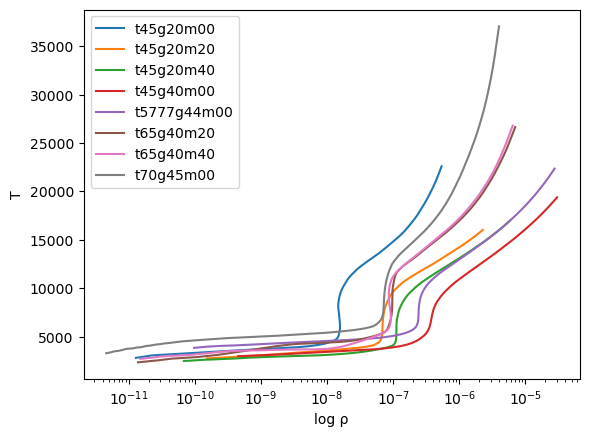

In [18]:
close()

for (i, model) in models |> enumerate
    plt.plot(exp.(model.lnρ), exp.(model.lnT), label=grid.info[i, "name"])
end

plt.xscale("log")
#plt.yscale("log")

plt.xlabel("log ρ")
plt.ylabel("T")


plt.legend()

gcf()

In [19]:
TT, rr = meshgrid(eos.lnT, eos.lnRho);

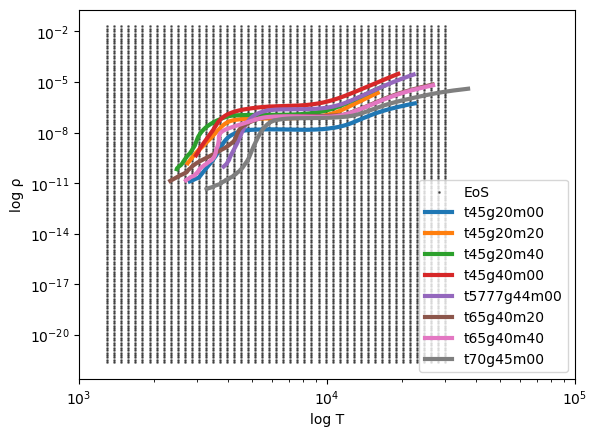

In [20]:
close()

plt.scatter(exp.(TT), exp.(rr), s=1, color="k", alpha=0.5, label="EoS")

for (i, model) in models |> enumerate
    plt.plot(exp.(model.lnT), exp.(model.lnρ), label=grid.info[i, "name"], lw=3)
end

plt.xscale("log")
plt.yscale("log")

plt.xlabel("log T")
plt.ylabel("log ρ")

plt.xlim(1e3, 1e5)

plt.legend()

gcf()